# **Language Learning on Duolingo: *Patterns from the Data***

## Introduction
Duolingo is a popular language-learning platform that offers courses in 43 languages (both real and fictional) to over 500 million users. The app uses games and quizzes to teach the learner vocabulary, grammar, and pronunciation.

The data used in this analysis was collected through a web scrape of [this website](https://duolingodata.com). 

To better organise the data, I created an SQLite database where each table corresponds to a unique origin language.

I am interested in determining how language popularity varies based on origin, as well as how the design of the course affects the number of learners.

### *Importing Data and Libraries*

In [62]:
import sqlite3
import pandas as pd
import os
import matplotlib.pyplot as plt

base_dir = os.getcwd()
db_path = os.path.join(base_dir, 'data', 'duolingoDatabase.db')
image_path = os.path.join(base_dir, 'images')

conn = sqlite3.connect(db_path)
query = """
SELECT
    a.id,
    a.learning,
    o.origin_name AS origin,
    a.u,
    a.lr,
    a.ls,
    a.s,
    a.w,
    a.r,
    a.d,
    a.cefr
FROM all_data a
JOIN origins o ON a.origin_id = o.id
"""
df = pd.read_sql_query(query, conn)


origins_df = pd.read_sql_query('SELECT origin_name, language_name, countries FROM origins', conn)
countries_df = pd.read_sql_query('SELECT * FROM language_countries', conn)
conn.close()
print(df.head())
print(origins_df.head())
print(countries_df.head())

   id learning origin    u     lr    ls  s     w      r    d cefr
0   1   Arabic     EN   46   8.55   798  0  1519  24.05   46     
1   2  Chinese     EN   70  11.90  1696  0  2036  25.03  490   A1
2   4    Czech     EN   88   1.00  1592  0  2696  24.05   88     
3   5   Danish     EN   62   1.11  1004  0  2341  24.05   62     
4   6    Dutch     EN  123   3.37  2039  0  2995  24.05  123     
  origin_name language_name                                          countries
0          AR        Arabic  Egypt, Saudi Arabia, Iraq, Jordan, United Arab...
1          BN       Bengali                                         Bangladesh
2          CS         Czech                                     Czech Republic
3          DE        German  Germany, Austria, Switzerland, Liechtenstein, ...
4          EL         Greek                                     Greece, Cyprus
  origin_name          country_name
0          AR                 Egypt
1          AR          Saudi Arabia
2          AR         

## Language Popularity

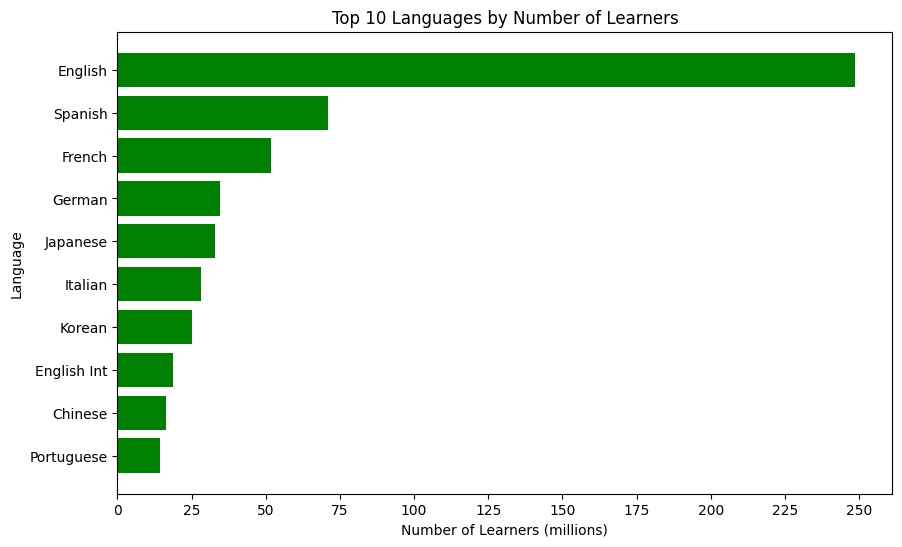

In [63]:
# Getting the top 10 languages by number of learners
top_10_languages = df.groupby("learning")["lr"].sum().sort_values(ascending=False).head(10).iloc[::-1]

# Plotting the top 10 languages
plt.figure(figsize=(10, 6))
plt.barh(top_10_languages.index, top_10_languages.values, color="green")

plt.xlabel("Number of Learners (millions)")
plt.ylabel("Language")
plt.title("Top 10 Languages by Number of Learners")
plt.xticks(range(0,275,25))

plt.savefig(os.path.join(image_path, "top_10_languages.png"))
plt.show()



This graph shows the number of learners for each language. With 250 million learners, English is the most popular language. Spanish and French are the second and third most popular languages. This is as expected, as all origin languages on Duolingo allow users to learn English. 

Interestingly, the total number of learners with English as their origin language is 263.36 million (from dataInvestigation.sql); this is similar to the number of learners learning English as a target language (250 million). This suggests that the majority of users on Duolingo can speak English, either as a first or second language.

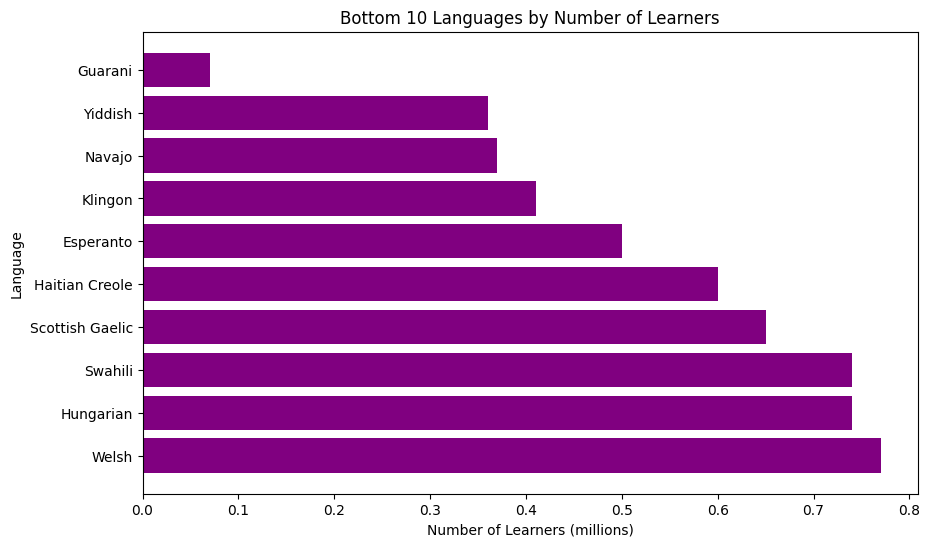

In [64]:
# Getting the bottom 10 languages by number of learners
bottom_10_languages = df.groupby("learning")["lr"].sum().sort_values(ascending=True).head(10).iloc[::-1]

# Plotting the bottom 10 languages
plt.figure(figsize=(10, 6))
plt.barh(bottom_10_languages.index, bottom_10_languages.values, color='purple')
plt.title('Bottom 10 Languages by Number of Learners')
plt.xlabel('Number of Learners (millions)')
plt.ylabel('Language')

plt.savefig(os.path.join(image_path, "bottom_10_languages.png"))

plt.show()



The language with the fewest learners is Guarani (spoken in Paraguay), with less than 100,000 learners. This may be because this course is only offered to Spanish speakers. The other least learnt languages include fictional languages, such as Klingon as well as regional languages, such as Welsh and Scottish Gaelic. 

Most of the least learnt languages are only offered to English speakers. This may be because these languages are not widely spoken outside of their native countries.

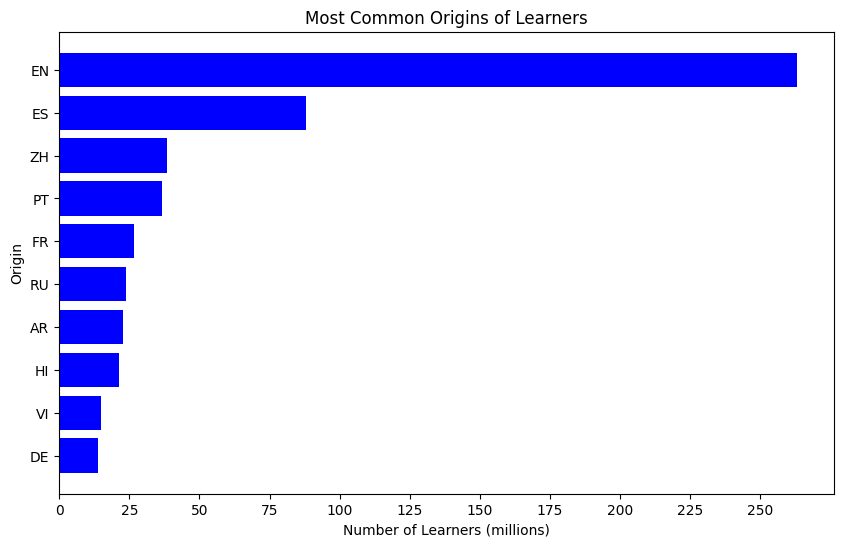

In [65]:
mostcommonorigin = df.groupby("origin")["lr"].sum().sort_values(ascending=False).head(10).iloc[::-1]
# Plotting the most common origins
plt.figure(figsize=(10, 6))
plt.barh(mostcommonorigin.index, mostcommonorigin.values, color="blue")
plt.xlabel("Number of Learners (millions)")
plt.ylabel("Origin")
plt.title("Most Common Origins of Learners")
plt.xticks(range(0, 275, 25))
plt.savefig(os.path.join(image_path, "most_common_origins.png"))
plt.show()


This shows that English is by far the most popular origin language on Duolingo, followed by Spanish and Chinese. This is not surprising, as these languages are spoken by the largest populations in the world.

## Language Pair Popularity

### Who's Learning What?

In [66]:
import plotly.graph_objects as go

# Grouping the data by origin and learning 
df_grouped = df.groupby(['origin', 'learning'])['lr'].sum().reset_index()

# Filtering so only flows with more than 2 million learners are shown
df_grouped_filter = df_grouped[df_grouped['lr'] > 2].copy()

# Create list of unique labels
labels = list(set(df_grouped_filter['origin'].tolist() + df_grouped_filter['learning'].tolist()))

# Map labels to indices
label_to_index = {label: i for i, label in enumerate(labels)}
df_grouped_filter['source'] = df_grouped_filter['origin'].map(label_to_index)
df_grouped_filter['target'] = df_grouped_filter['learning'].map(label_to_index)

# Create Sankey Diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=df_grouped_filter['source'],
        target=df_grouped_filter['target'],
        value=df_grouped_filter['lr']
    )
))

fig.update_layout(title_text="Flow of Learners: Origin → Learning Language", font_size=10)
fig.show()


This clearly shows that for every origin language, English is the most popular (or only target with over 3 million) learners. Few countries have multiple origin languages, these include: English, Portuguese, French, Italian, Spanish, Japanese and Korean. This is likely because people may be choosing to learn a language that is geographically close to them.

To follow on from this graph, I will produce a similar graph, but excluding English as a target language. 

In [67]:
# Creating a Sankey diagram exclusing English as a learning and origin language
df_grouped_no_english = df_grouped[~df_grouped['origin'].isin(['EN']) & ~df_grouped['learning'].isin(['English'])]

# Filtering so only flows with more than 1 million learners are shown
df_grouped_no_english = df_grouped_no_english[df_grouped_no_english['lr'] > 1].copy()

# Create list of unique labels
labels = list(set(df_grouped_no_english['origin'].tolist() + df_grouped_no_english['learning'].tolist()))

# Map labels to indices
label_to_index = {label: i for i, label in enumerate(labels)}
df_grouped_no_english['source'] = df_grouped_no_english['origin'].map(label_to_index)
df_grouped_no_english['target'] = df_grouped_no_english['learning'].map(label_to_index)


# Create Sankey Diagram
fig_no_english = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=df_grouped_no_english['source'],
        target=df_grouped_no_english['target'],
        value=df_grouped_no_english['lr']
    )
))
fig_no_english.update_layout(title_text="Flow of Learners (Excluding English)", font_size=10)
fig_no_english.show()

This graph makes it easier to see which languages people are most likely to learn. From this it appears that people that speak a European language are more likely to learn another European language, and people that speak an Asian language are more likely to learn another Asian language. This is likely due to the fact that these languages are geographically close to each other, and therefore people are more likely to be exposed to them.

### Second Most Popular Target Language
I have chosen to show the most popular target language for each origin after excluding English, as for all countries English is the most popular target language.

In [68]:
import plotly.express as px

# Excluding English as a learning language
df_filtered = df_grouped[df_grouped['learning'] != 'English']

# Sort by learners (descending) within each origin group
df_grouped_sorted = df_filtered.sort_values(['origin', 'lr'], ascending=[True, False])

# Keep the second entry per origin (i.e., second most popular)
df_second = df_grouped_sorted.groupby('origin').first().reset_index()

map_data = pd.merge(countries_df, df_second, left_on='origin_name', right_on='origin', how='inner')

# Select and rename columns
map_data = map_data[['country_name', 'learning', 'lr']]
map_data.rename(columns={'country_name': 'Country', 'learning': 'Learning', 'lr': 'learners'}, inplace=True)

# Making map
fig = px.choropleth(
    map_data,
    locations="Country",
    locationmode="country names",
    color="Learning",
    title="Most Popular Language Learned by Country (Excluding English)",
)

fig.show()



To make this graph, I used relational databases in SQL (as shown in the relationaldatabases.py file). Additionally I used pandas join.

I do not have information about which countries are learning which languages as the source data only includes the origin language and the target language. Therefore my map shows all the countries that speak a certain language, and the most popular target language for that language. E.g. UK, USA, Canada, Australia, New Zealand and South Africa all speak English, and the most popular target language for English speakers is Spanish. Where countries have multiple native languages, I have chosen to show them as speaking the most popular, for example, Canada is shown as speaking English. 

This map shows that other than English, the most popular target language is Spanish. This is likely due to the fact that Spanish is the second most spoken language in the world, and is spoken in many countries. It is notable that this is not the case in Russia, where the most popular (other than English) is German. This is likely because of historical interactions between the two countries, and the fact that Germany is geographically close to Russia.

## Individial Origin Language Analysis
I will now look at the most popular target language for each origin language. This will be done through a pie chart, so that I can see the proportion of learners for each target language.

In [69]:
# Define a threshold for grouping smaller sections
threshold = 1  # minimum percentage to show

# Group languages with less than 1% of learners into "Other"
def group_small_sections(filtered_df):
    filtered_df = filtered_df.copy()
    total_lr = filtered_df['lr'].sum()
    filtered_df['percentage'] = (filtered_df['lr'] / total_lr) * 100
    grouped_df = filtered_df[filtered_df['percentage'] >= threshold]
    other_df = filtered_df[filtered_df['percentage'] < threshold]
    if not other_df.empty:
        grouped_df = pd.concat([grouped_df, pd.DataFrame({'learning': ['Other'], 'lr': [other_df['lr'].sum()]})])
    return grouped_df

# Get unique origins
origins = df_pie['origin'].unique()

# Create the pie chart for each origin
fig = go.Figure()
for origin in origins:
    # filter the DataFrame for the current origin
    filtered_df = df_pie[df_pie['origin'] == origin]
    grouped_df = group_small_sections(filtered_df)
    
    # Get the language name for the current origin
    language_name = filtered_df['language_name'].iloc[0]  
    
    # Add a pie chart trace
    fig.add_trace(go.Pie(
        labels=grouped_df['learning'],
        values=grouped_df['lr'],
        name=language_name,  # Use the language name for the trace name
        visible=(origin == origins[0])  # show the first origin by default
    ))

# Add dropdown menu and update layout
fig.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label=df_pie[df_pie['origin'] == origin]['language_name'].iloc[0],  # use the language name for the dropdown (rather than the code)
                    method='update',
                    args=[
                        {'visible': [o == origin for o in origins]},  # update the pie chart to show only the selected origin
                        {'title': f'Languages Learned by {df_pie[df_pie["origin"] == origin]["language_name"].iloc[0]} Speakers'}
                    ]
                )
                for origin in origins
            ],
            direction="down",
            showactive=True
        )
    ],
    title=f'Languages Learned by {df_pie[df_pie["origin"] == origins[0]]["language_name"].iloc[0]} Speakers',  
)

fig.show()

To use this pie chat, select the origin language you are interested in, and a pie chart will be displayed showing the proportion of learners for each target language. Currently, languages with less than 1% of learners are shown as "Other". This is to make the pie chart easier to read, and to show the most popular target languages.

For all languages (excluding English), English is the most popular target language. This can be as high as 97.4% of learners (for Telugu). For some it is not as high, such as 39.8% for Swedish. 

## Regression Analysis: what affects the number of learners?

In [70]:
# Running a regression to see which element (i.e. number of lessons, number of units etc.) results in the most learners
import statsmodels.api as sm

# Creating a new DataFrame with the relevant columns
df_regression = df[['lr', 'ls', 's', 'w']].copy()
# Renaming columns for clarity

df_regression.rename(columns={
    'lr': 'learners',
    'ls': 'lessons',
    's': 'stories',
    'w': 'words'
}, inplace=True)


# Define independent variables (X) and dependent variable (y)
X = df_regression[['lessons', 'stories', 'words']]
X = sm.add_constant(X)
y = df_regression['learners']
# Fit the regression model
model = sm.OLS(y, X).fit()
# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               learners   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     40.96
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           1.04e-21
Time:                        14:39:48   Log-Likelihood:                -815.59
No. Observations:                 264   AIC:                             1639.
Df Residuals:                     260   BIC:                             1653.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4370      0.924     -2.636      0.0

This regression shows that the number of lessons is positiviely correlated with the number of learners. This is likely because the more lessons there are, the more content there is for learners to engage with. This is significant at the 0.01 level. Both the number of stores and the number of words in the course are not significant at the 0.01 level or 0.05 level. This suggests that the number of stores and the number of words in the course do not have a significant effect on the number of learners.

This is likely because the number of stores and the number of words in the course are not as important as the number of lessons. This is likely because the number of lessons is a better indicator of the amount of content in the course, whereas the number of stores and the number of words in the course are not as important.

The R-squared value is 0.321 which suggests that this model accounts for 32.1% of the variance in the data. This is a relatively low R-squared value, which suggests that there are other factors that affect the number of learners that are not included in this model.
There is both a high skew and high kurtosis in the data, which suggests that the data is not normally distributed. This is likely because there are a few languages with a very high number of learners, which skews the data. Additionally, there are a few languages with a very low number of learners, which also skews the data. This suggests that the data is not normally distributed, and therefore a linear regression model may not be the best fit for this data.


## Conclusion
This analysis has used data about Duolingo courses to determine what drives language learning trends globally. Some of the key findings include:
- **English dominates**, English is by far the most popular language on Duolingo with over 250 million learners. 
- **Regional and cultural factors** play a role in determining the second most popular target language. Europeans are more likely to learn another European language, and Asians are more likely to learn another Asian language.
- **Proportion of learners** for each target language varies by origin language. For example, Telugu speakers are more likely to learn English than Swedish speakers.
- **Course structure** has limited impact on the number of learners. The number of lessons is positively correlated with the number of learners, but the number of stores and the number of words in the course are not significant.

## Project Conclusion

Within this project, I have highlighted how Duolingo language learning data shows how language popularity varies based on origin (and less so on the course structure). I have shown that English is by far the most popular language to learn on Duolingo and is followed by Spanish. Most learners on Duolingo speak English (possibly because the app is originally from the USA). 

As mentioned, this blog has shown that course structure has limited impact on the number of learners. The only significant factor is the number of lessons, which is positively correlated with the number of learners. This suggests that the more content there is for learners to engage with, the more likely they are to learn a language.

This project involved using web scraping to collect data from an online source, and then I used SQL to create a relational database and clean the data. The use of SQL allowed me to create a database that was easy to query and contained all the information I needed, without having unnecessary data. Within the blog, I have used pandas to create and manipulate dataframes (such as through joins) and I have created visualisations using matplotlib and plotly. 

To further my analysis, I would like to include more data about the learners, such as age, gender and country of origin. This would allow me to determine if there are any trends in the data that are not currently visible. Additionally, I would like to be able to make recommendations, based on the data, about which languages Duolingo should offer courses in.